---

##  Import Libraries

In [1]:
import numpy as np
from sklearn.metrics import precision_recall_fscore_support
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, BatchNormalization
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import time
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings('ignore')

---

##  Load Data

In [2]:
X_train = pd.read_csv('Dataset/X_train_100.csv')
y_train = pd.read_csv('Dataset/y_train_100.csv').iloc[:, 0]
X_test = pd.read_csv('Dataset/X_test.csv')
y_test = pd.read_csv('Dataset/y_test.csv').iloc[:, 0]

---

##  Check Data Info

In [3]:
print("📊 Data Information:")
print(f"Training features shape: {X_train.shape}")
print(f"Training labels shape: {y_train.shape}")
print(f"Test features shape: {X_test.shape}")
print(f"Test labels shape: {y_test.shape}")

print(f"\nNumber of classes: {len(np.unique(y_train))}")
print(f"Classes: {sorted(np.unique(y_train))}")

print("\nClass distribution in training data:")
print(y_train.value_counts().sort_index())

📊 Data Information:
Training features shape: (235700, 20)
Training labels shape: (235700,)
Test features shape: (37792, 20)
Test labels shape: (37792,)

Number of classes: 5
Classes: [np.int64(0), np.int64(1), np.int64(2), np.int64(3), np.int64(4)]

Class distribution in training data:
0
0    47140
1    47140
2    47140
3    47140
4    47140
Name: count, dtype: int64


---

##  Convert to NumPy Arrays

In [4]:
X_train_np = X_train.values.astype(np.float32)
X_test_np = X_test.values.astype(np.float32)
y_train_np = y_train.values.astype(np.int32)
y_test_np = y_test.values.astype(np.int32)

print("🔧 Data converted to neural network format")
print(f"X_train shape: {X_train_np.shape}")
print(f"X_test shape: {X_test_np.shape}")
print(f"y_train shape: {y_train_np.shape}")
print(f"y_test shape: {y_test_np.shape}")

🔧 Data converted to neural network format
X_train shape: (235700, 20)
X_test shape: (37792, 20)
y_train shape: (235700,)
y_test shape: (37792,)


---

##  Get Dimensions

In [5]:
n_features = X_train_np.shape[1]
n_classes = len(np.unique(y_train_np))

print(f"📈 Neural network dimensions:")
print(f"Input features: {n_features}")
print(f"Output classes: {n_classes}")
print(f"Training samples: {X_train_np.shape[0]:,}")
print(f"Test samples: {X_test_np.shape[0]:,}")

📈 Neural network dimensions:
Input features: 20
Output classes: 5
Training samples: 235,700
Test samples: 37,792


---

##  Build MLP Model

In [6]:
mlp_model = Sequential([

    Dense(128, activation='relu', input_shape=(n_features,), name='hidden_1'),
    BatchNormalization(),
    Dropout(0.3),


    Dense(64, activation='relu', name='hidden_2'),
    BatchNormalization(),
    Dropout(0.3),


    Dense(32, activation='relu', name='hidden_3'),
    BatchNormalization(),
    Dropout(0.2),


    Dense(n_classes, activation='softmax', name='output')
])

---

##  Display Model Architecture

In [7]:
mlp_model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ hidden_1 (Dense)                │ (None, 128)            │         2,688 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 128)            │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_2 (Dense)                │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 64)             │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ hidden_3 (Dense)                │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 32)             │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 32)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ output (Dense)                  │ (None, 5)              │           165 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,085 (55.02 KB)

 Trainable params: 13,637 (53.27 KB)

 Non-trainable params: 448 (1.75 KB)

---

##  Compile Model

In [8]:
mlp_model.compile(
    optimizer=Adam(learning_rate=0.001),
    loss='sparse_categorical_crossentropy',
    metrics=['accuracy']
)

---

##  Setup Callbacks

In [9]:
callbacks = [
    EarlyStopping(
        monitor='val_accuracy',
        patience=10,
        restore_best_weights=True,
        verbose=1
    ),
    ReduceLROnPlateau(
        monitor='val_accuracy',
        factor=0.5,
        patience=5,
        min_lr=1e-7,
        verbose=1
    )
]

---

##  Start Training

In [10]:
train_start_time = time.time()

---

##  Train the Model

In [11]:
history = mlp_model.fit(
    X_train_np, y_train_np,
    validation_data=(X_test_np, y_test_np),
    epochs=100,
    batch_size=256,
    callbacks=callbacks,
    verbose=1
)

Epoch 1/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 13s 8ms/step - accuracy: 0.8743 - loss: 0.3837 - val_accuracy: 0.9623 - val_loss: 0.1213 - learning_rate: 0.0010
Epoch 2/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9738 - loss: 0.0923 - val_accuracy: 0.9698 - val_loss: 0.0990 - learning_rate: 0.0010
Epoch 3/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - accuracy: 0.9801 - loss: 0.0713 - val_accuracy: 0.9757 - val_loss: 0.0799 - learning_rate: 0.0010
Epoch 4/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 4s 4ms/step - accuracy: 0.9827 - loss: 0.0609 - val_accuracy: 0.9806 - val_loss: 0.0634 - learning_rate: 0.0010
Epoch 5/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9842 - loss: 0.0555 - val_accuracy: 0.9820 - val_loss: 0.0583 - learning_rate: 0.0010
Epoch 6/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step - accuracy: 0.9859 - loss: 0.0489 - val_accuracy: 0.9812 - val_loss: 0.0559 - learning_rate: 0.0010
Epoch 7/100
921/921 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.9867 - loss: 0

---

##    Calculate Training Time

In [12]:
train_end_time = time.time()
training_time = train_end_time - train_start_time

print(f"\n Training completed in {training_time:.2f} seconds")


 Training completed in 298.34 seconds


In [13]:
print(" Calculating training accuracy...")
train_pred_start = time.time()

y_train_pred_proba = mlp_model.predict(X_train_np, verbose=0)
y_train_pred = np.argmax(y_train_pred_proba, axis=1)

train_pred_end = time.time()
train_pred_time = train_pred_end - train_pred_start

training_accuracy = accuracy_score(y_train_np, y_train_pred)

print(f" Training prediction completed in {train_pred_time:.2f} seconds")
print(f" Training Accuracy: {training_accuracy:.4f} ({training_accuracy*100:.2f}%)")

 Calculating training accuracy...
 Training prediction completed in 15.71 seconds
 Training Accuracy: 0.9981 (99.81%)


---

##    Make Predictions

In [14]:
test_start_time = time.time()

y_pred_proba = mlp_model.predict(X_test_np, verbose=0)
y_pred = np.argmax(y_pred_proba, axis=1)

test_end_time = time.time()
testing_time = test_end_time - test_start_time

print(f"⏱️ Testing completed in {testing_time:.2f} seconds")

⏱️ Testing completed in 2.20 seconds


---

##    Calculate Accuracy

In [15]:
test_accuracy = accuracy_score(y_test_np, y_pred)

print(f" MLP Test Accuracy: {test_accuracy:.4f} ({test_accuracy*100:.2f}%)")

 MLP Test Accuracy: 0.9947 (99.47%)


---

##    Detailed Performance Metrics

In [16]:
precision, recall, f1, _ = precision_recall_fscore_support(y_test_np, y_pred, average='weighted')
train_precision, train_recall, train_f1, _ = precision_recall_fscore_support(y_train_np, y_train_pred, average='weighted')
print(" DETAILED MLP PERFORMANCE:")
print("="*40)
print("TRAINING SET:")
print(f"Accuracy:  {training_accuracy:.4f}")
print(f"Precision: {train_precision:.4f}")
print(f"Recall:    {train_recall:.4f}")
print(f"F1-Score:  {train_f1:.4f}")
print()
print("TEST SET:")
print(f"Accuracy:  {test_accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"Recall:    {recall:.4f}")
print(f"F1-Score:  {f1:.4f}")
print()
print("TIMING:")
print(f"Training time: {training_time:.2f} seconds")
print(f"Testing time: {testing_time:.2f} seconds")
print("="*40)

 DETAILED MLP PERFORMANCE:
TRAINING SET:
Accuracy:  0.9981
Precision: 0.9981
Recall:    0.9981
F1-Score:  0.9981

TEST SET:
Accuracy:  0.9947
Precision: 0.9960
Recall:    0.9947
F1-Score:  0.9952

TIMING:
Training time: 298.34 seconds
Testing time: 2.20 seconds


---

##    Classification Report

In [17]:
print("📋 Detailed Classification Report:")
print(classification_report(y_test_np, y_pred))

📋 Detailed Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     13778
           1       0.99      1.00      0.99      3497
           2       0.76      0.97      0.85       298
           3       0.29      1.00      0.45        16
           4       1.00      0.99      1.00     20203

    accuracy                           0.99     37792
   macro avg       0.81      0.99      0.86     37792
weighted avg       1.00      0.99      1.00     37792



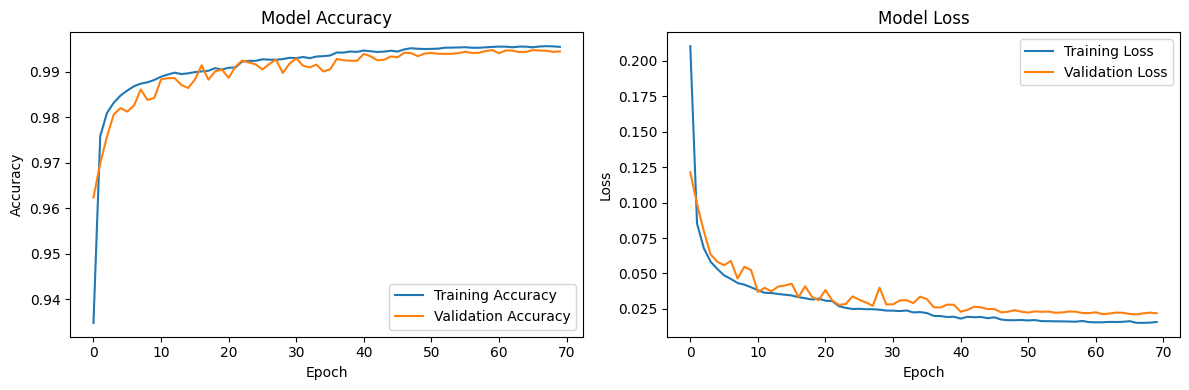

In [18]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

---

##   Summary Results

In [19]:
print(" MLP NEURAL NETWORK FINAL SUMMARY:")
print("="*50)
print(f"Architecture: 3 hidden layers (128→64→32)")
print(f"Total parameters: {mlp_model.count_params():,}")
print(f"Training time: {training_time:.2f}s")
print(f"Training accuracy: {training_accuracy:.4f}")
print(f"Test accuracy: {test_accuracy:.4f}")
print(f"Accuracy gap: {(training_accuracy-test_accuracy)*100:.2f}%")

 MLP NEURAL NETWORK FINAL SUMMARY:
Architecture: 3 hidden layers (128→64→32)
Total parameters: 14,085
Training time: 298.34s
Training accuracy: 0.9981
Test accuracy: 0.9947
Accuracy gap: 0.34%
